Basic programs I'll for sure need, more will be added as needed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline

In [2]:
import pandas_datareader.data as web
import datetime

### Section 1: Measuring reactions to FOMC announcements

There's no real way to tell how expected or unexpected an FOMC announcement is, but one common practice is to measure changes in U.S. Treasury yields in the days following announcements. There is some disagreement over how many days post-announcement to track, but this analysis will use changes in yields on FOMC days.

I first imported daily 2-year U.S. Treasury yields since January 1, 2008 via the FRED API. 

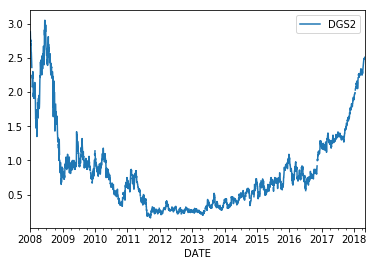

In [3]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
codes = ['DGS2'] #DGS2 = 2-Year Treasury Constant Maturity Rate, daily frequency
fred = web.DataReader(codes, 'fred', start, end)

fred.plot()

In [4]:
fred.head()

,DGS2
DATE,
2008-01-01,NaN
2008-01-02,2.88
2008-01-03,2.83
2008-01-04,2.74
2008-01-07,2.76


I want the daily change in yields, so I add that column

In [5]:
fred = fred.assign(delta = 100*fred.pct_change())
fred.head()

,DGS2,delta
DATE,,
2008-01-01,NaN,NaN
2008-01-02,2.88,NaN
2008-01-03,2.83,-1.736111
2008-01-04,2.74,-3.180212
2008-01-07,2.76,0.729927


In [8]:
fred = fred.rename(columns = {'DGS2' : '2yr_yield', 'delta' : 'daily_pct_change'})
fred.head()

,2yr_yield,daily_pct_change
DATE,,
2008-01-01,NaN,NaN
2008-01-02,2.88,NaN
2008-01-03,2.83,-1.736111
2008-01-04,2.74,-3.180212
2008-01-07,2.76,0.729927


I only want to know this data on FOMC announcement days. Unfortunately, there isn't an API for these dates, so I had to manually enter the dates from the [FOMC's website](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm) calendar into an Excel sheet (available in my GitHub repository). 

In [9]:
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas import read_csv

In [10]:
path = '/Users/simon.ilisevich/Documents/Data_Bootcamp/fomc_dates.csv'
fomc_dates = read_csv(path, index_col='Date', usecols=['Date','Announcements'])

In [12]:
fomc_dates.index.names = ['DATE']
fomc_dates.head()

,Announcements
DATE,
2008-10-08,FFR target decrease *intermeeting
2008-10-29,FFR target decrease
2008-11-25,MBS and agency debt purchase *intermeeting
2008-12-16,FFR target decrease
2009-01-28,NaN


Using the FOMC dates, I create a new dataframe that only includes yields and daily changes in yield on FOMC days

In [13]:
fomc_dates = fomc_dates.join(fred)

In [14]:
fomc_dates.head()

,Announcements,2yr_yield,daily_pct_change
DATE,,,
2008-10-08,FFR target decrease *intermeeting,1.65,12.244898
2008-10-29,FFR target decrease,1.58,-4.242424
2008-11-25,MBS and agency debt purchase *intermeeting,1.15,-12.213740
2008-12-16,FFR target decrease,0.65,-13.333333
2009-01-28,NaN,0.89,2.298851


In [15]:
fomc_dates.index

DatetimeIndex(['2008-10-08', '2008-10-29', '2008-11-25', '2008-12-16',
               '2009-01-28', '2009-03-18', '2009-04-29', '2009-06-24',
               '2009-08-12', '2009-09-23', '2009-11-04', '2009-12-16',
               '2010-01-27', '2010-03-16', '2010-04-28', '2010-06-23',
               '2010-08-10', '2010-09-21', '2010-11-03', '2010-12-14',
               '2011-01-26', '2011-03-15', '2011-04-27', '2011-06-22',
               '2011-08-09', '2011-09-21', '2011-11-02', '2011-12-13',
               '2012-01-25', '2012-03-13', '2012-04-25', '2012-06-20',
               '2012-08-01', '2012-09-13', '2012-10-24', '2012-12-12',
               '2013-01-30', '2013-03-20', '2013-05-01', '2013-06-19',
               '2013-09-18', '2013-10-30', '2013-12-18', '2014-01-29',
               '2014-03-19', '2014-04-30', '2014-06-18', '2014-07-30',
               '2014-09-17', '2014-10-29', '2014-12-17', '2015-01-28',
               '2015-03-18', '2015-04-29', '2015-06-17', '2015-07-29',
      

In [18]:
fred_mean = fred['daily_pct_change'].mean()
fred_std = fred['daily_pct_change'].std()

print(fred_mean)
print(fred_std)

0.13556977235635276
5.324606758338174


In [132]:
z = 2*fred_std + fred_mean
z

10.784783289032701

Text(63,24,'MBS-purchase reduction')

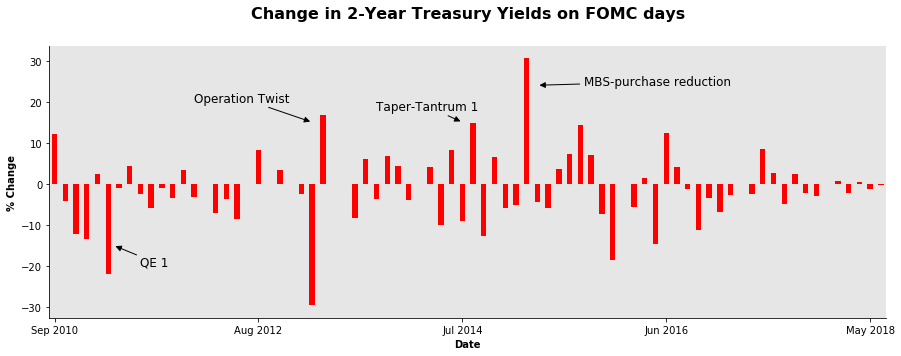

In [231]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_facecolor('0.9')

import matplotlib.ticker as ticker

clr1 = 'r'
clr2 = 'g'
clrs = [clr1 if var >= z else clr2 for var in fomc_dates['daily_pct_change']]

fomc_dates.daily_pct_change.plot(kind='bar', 
                                 ax=ax,
                                color = clrs)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title("Change in 2-Year Treasury Yields on FOMC days", fontsize=16, fontweight = "bold", y=1.08)
ax.set_ylabel("% Change", fontweight="bold") 
ax.set_xlabel("Date", fontweight='bold')

labels = ['Oct 2008', 'Sep 2010', 'Aug 2012', 'Jul 2014', 'Jun 2016', 'May 2018']
plt.gca().set_xticklabels(labels, rotation=0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(19))

ax.annotate("QE 1", xy=(5.5, -15.0), xycoords="data", xytext=(8.0, -20.0), horizontalalignment="left", 
arrowprops={"arrowstyle": "-|>",  "color": "black"}, fontsize=12,)

ax.annotate("Operation Twist", xy=(24, 15.0), xycoords="data", xytext=(13.0, 20.0), horizontalalignment="left", 
arrowprops={"arrowstyle": "-|>", "color": "black"},fontsize=12,)

ax.annotate("Taper-Tantrum 1", xy=(38, 15.0), xycoords="data", xytext=(30.0, 18.0), horizontalalignment="left", 
arrowprops={"arrowstyle": "-|>", "color": "black"},fontsize=12,)

ax.annotate("MBS-purchase reduction", xy=(45, 24.0), xycoords="data", xytext=(63.0, 24.0), horizontalalignment="right", 
arrowprops={"arrowstyle": "-|>", "color": "black"},fontsize=12,)

### Section 2: Importing Chinese, Indian, and Russian market reactions

The next step is to measure changes in equity prices, exchange rates, and bond yields among three of the four largest emerging market economies. Data for this entire section came from the Stooq Index Data API. While not the easiest API to work with, it was the only API I could find that provided data for all three categories across the entire test period. 

The same importing, cleaning, and merging process is repeated for all three categories. It's explained in the equities section.

#### Equities
These are the largest equity indeces for each country from the Stooq Index Data API

China - Shanghai Composite Index

In [229]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ch_equities = web.DataReader('^SHC', 'stooq', start, end)
ch_equities.head()

""
Exceeded the daily hits limit


India - BSE SENSEX

In [21]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
in_equities = web.DataReader('^SNX', 'stooq', start, end)
in_equities.head()

""
Exceeded the daily hits limit


Russia - RTS Index

In [22]:
start = ['2008-01-01']
end = ['2018-05-04']
ru_equities = web.DataReader('^RTS', 'stooq', start, end)
ru_equities.head()

""
Exceeded the daily hits limit


Getting rid of unecessary columns

In [23]:
ch_equities = ch_equities.drop(ch_equities.columns[[0, 1, 2, 4]], axis=1) 
in_equities = in_equities.drop(in_equities.columns[[0, 1, 2, 4]], axis=1) 
ru_equities = ru_equities.drop(ru_equities.columns[[0, 1, 2, 4]], axis=1) 

IndexError: index 0 is out of bounds for axis 1 with size 0

Adding in daily percentage change

In [27]:
ch_equities = ch_equities.assign(ch_equity_change = 100*ch_equities.pct_change())
in_equities = in_equities.assign(in_equity_change = 100*in_equities.pct_change())
ru_equities = ru_equities.assign(ru_equity_change = 100*ru_equities.pct_change())

ValueError: Wrong number of items passed 0, placement implies 1

Each DataFrame has a slightly different index, so I need to create a common index among all three in order to make merging them easier

In [ ]:
idx = pd.date_range('2008-01-01', '2018-05-04')

In [ ]:
ch_equities.index = pd.DatetimeIndex(ch_equities.index)
ch_equities = ch_equities.reindex(idx, fill_value='NaN')

in_equities.index = pd.DatetimeIndex(in_equities.index)
in_equities = in_equities.reindex(idx, fill_value='NaN')

ru_equities.index = pd.DatetimeIndex(ru_equities.index)
ru_equities = ru_equities.reindex(idx, fill_value='NaN')

Dropping now unecessary Close prices

In [ ]:
ch_equities = ch_equities.drop('Close', 1)
in_equities = in_equities.drop('Close', 1)
ru_equities = ru_equities.drop('Close', 1)

New table with emerging market equity reactions included 

In [24]:
market_response = fomc_dates.join(ch_equities, how='left', lsuffix='_left', rsuffix='_right').join(in_equities, how='left', lsuffix='_left', rsuffix='_right').join(ru_equities, how='left', lsuffix='_left', rsuffix='_right')
market_response.head()

,Announcements,2yr_yield,daily_pct_change
DATE,,,
2008-10-08,FFR target decrease *intermeeting,1.65,12.244898
2008-10-29,FFR target decrease,1.58,-4.242424
2008-11-25,MBS and agency debt purchase *intermeeting,1.15,-12.213740
2008-12-16,FFR target decrease,0.65,-13.333333
2009-01-28,NaN,0.89,2.298851


#### Exchange Rates

CNY/USD

In [ ]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ch_fx = web.DataReader('CNYUSD', 'stooq', start, end)

INR/USD

In [ ]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
in_fx = web.DataReader('INRUSD', 'stooq', start, end)

RUB/USD

In [ ]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ru_fx = web.DataReader('RUBUSD', 'stooq', start, end)

In [ ]:
ch_fx.head()

In [ ]:
ch_fx = ch_fx.drop(ch_fx.columns[[0, 1, 2]], axis=1) 
in_fx = in_fx.drop(in_fx.columns[[0, 1, 2]], axis=1) 
ru_fx = ru_fx.drop(ru_fx.columns[[0, 1, 2]], axis=1) 

In [ ]:
ch_fx = ch_fx.assign(ch_fx_change = 100*ch_fx.pct_change())
in_fx = in_fx.assign(in_fx_change = 100*in_fx.pct_change())
ru_fx = ru_fx.assign(ru_fx_change = 100*ru_fx.pct_change())

In [ ]:
ch_fx.index = pd.DatetimeIndex(ch_fx.index)
ch_fx = ch_fx.reindex(idx, fill_value='NaN')

in_fx.index = pd.DatetimeIndex(in_fx.index)
in_fx = in_fx.reindex(idx, fill_value='NaN')

ru_fx.index = pd.DatetimeIndex(ru_fx.index)
ru_fx = ru_fx.reindex(idx, fill_value='NaN')

In [ ]:
ch_fx = ch_fx.drop('Close', 1)
in_fx = in_fx.drop('Close', 1)
ru_fx = ru_fx.drop('Close', 1)

In [ ]:
market_response = market_response.join(ch_fx, how='left', lsuffix='_left', rsuffix='_right').join(in_fx, how='left', lsuffix='_left', rsuffix='_right').join(ru_fx, how='left', lsuffix='_left', rsuffix='_right')
market_response.head()

#### Bond Prices

Chinese 10-Year

In [ ]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ch_bond = web.DataReader('10CNY.B', 'stooq', start, end)

Indian 10-Year

In [ ]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
in_bond = web.DataReader('10INY.B', 'stooq', start, end)

Russian 10-Year

In [ ]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ru_bond = web.DataReader('10RUY.B', 'stooq', start, end)

In [ ]:
ru_bond.head()

In [ ]:
ch_bond = ch_bond.drop(ch_bond.columns[[0, 1, 2]], axis=1) 
in_bond = in_bond.drop(in_bond.columns[[0, 1, 2]], axis=1) 
ru_bond = ru_bond.drop(ru_bond.columns[[0, 1, 2]], axis=1) 

In [ ]:
ch_bond = ch_bond.assign(ch_bond_change = 100*ch_bond.pct_change())
in_bond = in_bond.assign(in_bond_change = 100*in_bond.pct_change())
ru_bond = ru_bond.assign(ru_bond_change = 100*ru_bond.pct_change())

In [ ]:
ch_bond.index = pd.DatetimeIndex(ch_bond.index)
ch_bond = ch_bond.reindex(idx, fill_value='NaN')

in_bond.index = pd.DatetimeIndex(in_bond.index)
in_bond = in_bond.reindex(idx, fill_value='NaN')

ru_bond.index = pd.DatetimeIndex(ru_bond.index)
ru_bond = ru_bond.reindex(idx, fill_value='NaN')

In [ ]:
ch_bond = ch_bond.drop('Close', 1)
in_bond = in_bond.drop('Close', 1)
ru_bond = ru_bond.drop('Close', 1)

In [ ]:
market_response = market_response.join(ch_bond, how='left', lsuffix='_left', rsuffix='_right').join(in_bond, how='left', lsuffix='_left', rsuffix='_right').join(ru_bond, how='left', lsuffix='_left', rsuffix='_right')
market_response.head()

In [ ]:
equity_response = market_response[['ch_equity_change', 'in_equity_change', 'ru_equity_change']].copy()
equity_response.head()

In [ ]:
fx_response = market_response[['ch_fx_change', 'in_fx_change', 'ru_fx_change']].copy()
fx_response.head()

In [ ]:
bond_response = market_response[['ch_bond_change', 'in_bond_change', 'ru_bond_change']].copy()
bond_response.head()

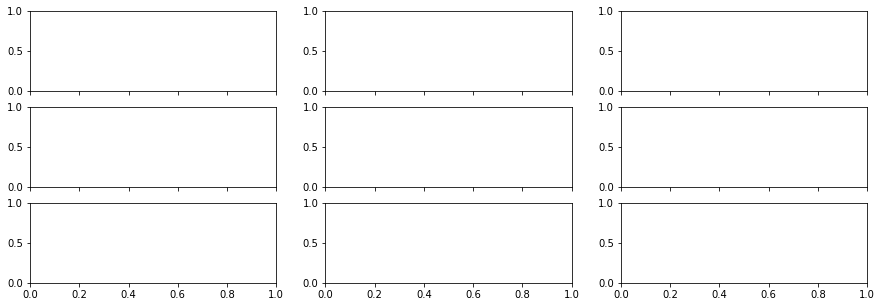

In [232]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, sharex = True, figsize = (15,5))

ax = ax.ravel()